# Step 6: All in one: Density profile scaling relations
* Calculate density profiles (in SQL).
* Fit to profile (NFW or Hernquist) 
* Show fits
* Plot parameters

(apologies for naive python)

In [1]:
import SciServer.CasJobs as cj
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
# load library for fitting
from scipy.optimize import curve_fit

In [2]:
# define fitting function from Hernquist 19..
# we will fit log of rdensity profile
def hern(radius, M, a):
    return np.log10(0.5*M*a/((radius)*(a+radius)**3)/math.pi)

In [3]:
# determine a stratified sample of halos (centers of FOF groups), strata based on mass
# note: ordering by newid() orders randomly
# note: uses ran() over(partition by...) to create the strata

# just in case a sample already exists, drop it
try:
    cj.executeQuery("drop table StratHaloSample","MyDB")
except:
    pass

sql="""
with h as ( 
select haloid, np, floor(log10(np)/.2) as npbin 
,      rank() over(partition by floor(log10(np)/.2) order by newid()) as rank
  from MR
 where snapnum=63 
   and haloid=firsthaloinfofgroupid 
)
select *
  into MyDB.StratHaloSample
  from h where rank <= 10
"""
%time cj.executeQuery(sql,"MPAHaloTrees")

CPU times: user 40.2 ms, sys: 4.35 ms, total: 44.5 ms
Wall time: 20.9 s


,Rows Affected
0,254


In [4]:
# create query to find particles in spheres around these halos
# note, this may take a while, hence run as Casjobs batch job and store result in MyDB table
# also note, use the SimulationDB database as context, because that is where all the spatial query functions are installed.

try:
    cj.executeQuery("drop table haloprofiles","MyDB")
except:
    pass


query="""
with ps as (
select h.haloId,p.x-hh.x as x,p.y-hh.y as y,p.z-hh.z as z, hh.np
from mydb.strathalosample h
   inner join mpahalotrees..mr hh
  on hh.haloid=h.haloid 
  and h.rank <= 8
  and h.npbin between 15 and 27
      cross apply dbo.MillenniumParticles(hh.snapnum,
      dbo.Sphere::New(hh.x,hh.y,hh.z,3*hh.halfmassradius).ToString()) p
),
rs as (
select haloid,sqrt(x*x+y*y+z*z) as r, np
from ps
)
select haloid, max(np) as np,
 power(convert(real,10 ),.1*floor(log10(r)/.1)) as r1
  , power(convert(real, 10),.1*(1+floor(log10(r)/.1))) as r2, count(*) as num
  into MyDB.haloprofiles
  from rs where r > 0
  group by haloid, floor(log10(r)/.1)
  order by 1,3
"""
jobid=cj.submitJob(query,"SimulationDB")
%time cj.waitForJob(jobid,verbose=True);

Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Done!
CPU times: user 458 ms, sys: 62.5 ms, total: 520 ms
Wall time: 1min 21s


{'JobID': 50107677,
 'Rows': 2728,
 'WebServicesID': 106816357,
 'TimeSubmit': '2021-01-09T22:01:56.927',
 'TimeStart': '2021-01-09T22:02:04.99',
 'TimeEnd': '2021-01-09T22:03:15.733',
 'SendEmail': 0,
 'Status': 5,
 'AutoComplete': 0,
 'Estimate': 500,
 'TaskName': 'Compute.SciScript-Python.CasJobs.submitJob',
 'OutputLoc': '',
 'HostIP': 'SimulationDB_lo',
 'Message': 'Query Complete',
 'Query': '\nwith ps as (\nselect h.haloId,p.x-hh.x as x,p.y-hh.y as y,p.z-hh.z as z, hh.np\nfrom mydb.strathalosample h\n   inner join mpahalotrees..mr hh\n  on hh.haloid=h.haloid \n  and h.rank <= 8\n  and h.npbin between 15 and 27\n      cross apply dbo.MillenniumParticles(hh.snapnum,\n      dbo.Sphere::New(hh.x,hh.y,hh.z,3*hh.halfmassradius).ToString()) p\n),\nrs as (\nselect haloid,sqrt(x*x+y*y+z*z) as r, np\nfrom ps\n)\nselect haloid, max(np) as np,\n power(convert(real,10 ),.1*floor(log10(r)/.1)) as r1\n  , power(convert(real, 10),.1*(1+floor(log10(r)/.1))) as r2, count(*) as num\n  into MyDB.ha

In [13]:
# retrieve the profiles
profs = cj.executeQuery("select * from haloprofiles order by haloId, r1", "MyDB")
haloIds = np.unique(profs['haloid'])
halosample=sorted(np.random.choice(haloIds,40))


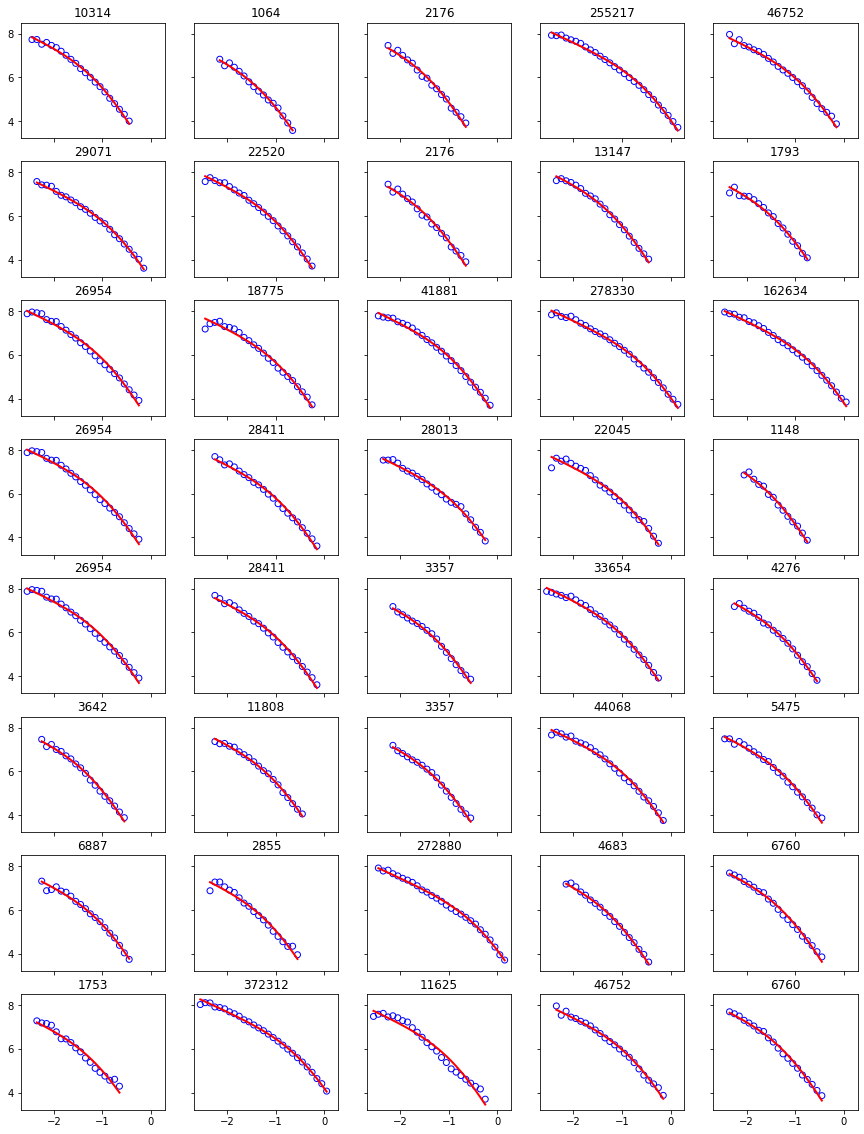

In [14]:
# fit profiles to hernquist profile and plot

# restrict to small sample for demo purposes
nmax=40
count=0
params=[]
cov=[]

fig, axs = plt.subplots(8,5, sharex=True, sharey=True,figsize=(15,20))

for ij,haloId in enumerate(halosample):
    if(ij >= nmax):
        break
    j=int(ij/8)
    i=ij-8*j
    
    df=profs.loc[(profs.haloid ==haloId), ['haloid','np','r1', 'r2', 'num']]
    hs=np.array(df['haloid'].tolist())
    n1=3
    n2=len(hs)-1
    npart=np.array(df['np'].tolist())[0]
    r1=np.array(df['r1'].tolist())[n1:n2]
    r2=np.array(df['r2'].tolist())[n1:n2]
    num=np.array(df['num'].tolist())[n1:n2]
    r=np.sqrt(r1*r2)
    v=4*math.pi*(r2**3-r1**3)/3
    d = num/v
    ld = np.log10(d)
    lr=np.log10(r)

    fitFunc=hern
    p0=[npart, 0.05]

#     fitFunc=nfw
#     p0=[1,1]

    fitParams, fitCovariances = curve_fit(fitFunc, r,ld, p0=p0)
    params.append(fitParams)
    cov.append(fitCovariances)
    
# plot density profiles as open dots and fit +/- 1 sigma as lines     
#     plt.subplot(8,5,subPlotNum, sharex=True, sharey=True)

    axs[i,j].scatter(lr, ld,facecolors='none', edgecolors='b')
    axs[i,j].plot(lr, (fitFunc(r, fitParams[0], fitParams[1])),c='red',linewidth=2)
#             lr, (fitFunc(r, fitParams[0] + np.sqrt(fitCovariances[0,0]), fitParams[1]- np.sqrt(fitCovariances[1,1]))),
#             lr, (fitFunc(r, fitParams[0] - np.sqrt(fitCovariances[0,0]), fitParams[1] + np.sqrt(fitCovariances[1,1]))))
    axs[i,j].set_title(str(npart))
    
# plt.show()


In [18]:
# fit mass vs scaling radius
def straight(lmass, a, b):
    return a*lmass+b

M,Rs=zip(*params)
p0=[2,0]
ab, errab = curve_fit(straight, np.log10(M), np.log10(Rs),p0=p0)
yy=[min(np.log10(M)), max(np.log10(M))]
xx=[straight(min(np.log10(M)),ab[0],ab[1]), straight(max(np.log10(M)),ab[0],ab[1])]


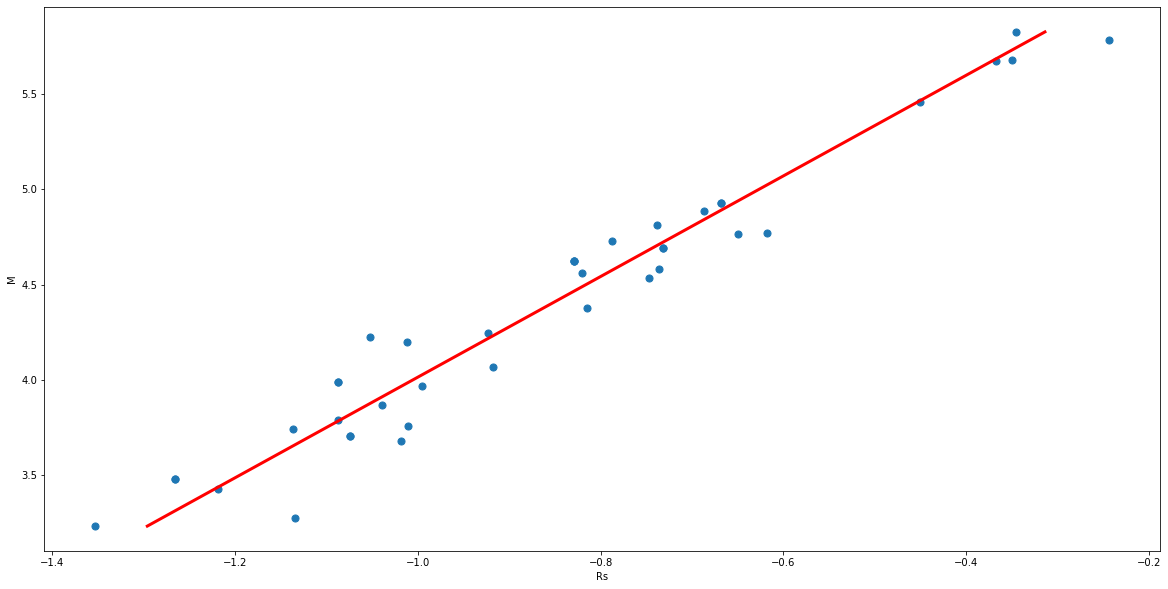

In [19]:
plt.figure(figsize=(20, 10))
plt.xlabel('Rs')
plt.ylabel('M')
plt.scatter(np.log10(Rs), np.log10(M),s=50)
plt.plot(xx, yy,c='red',linewidth=3)
plt.show()